## Date Proprecessing 
In this mission we will use Date, Time, Latitude, and Longitude to predict Magnitude of earthquake.
So at first we extract those data, and process time data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
earth_df = pd.read_csv('database.csv')
earth_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [42]:
# data we need
df = earth_df[['Date', 'Time', 'Latitude', 'Longitude','Magnitude']]
df.head()

,Date,Time,Latitude,Longitude,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,6.0
1,01/04/1965,11:29:49,1.863,127.352,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,5.8
4,01/09/1965,13:32:50,11.938,126.427,5.8


In [22]:
date_split = lambda x: pd.Series([i for i in x.split('/')])
time_split = lambda x: pd.Series([i for i in x.split(':')])

In [43]:
df[['Day','Month','Year']] = df['Date'].apply(date_split)
df[['Hour', 'Minute', 'Second']] = df['Time'].apply(time_split)

/home/andy/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [44]:
df = df.drop(['Date','Time'], axis=1)
df.head()

,Latitude,Longitude,Magnitude,Day,Month,Year,Hour,Minute,Second
0,19.246,145.616,6.0,01,02,1965,13,44,18
1,1.863,127.352,5.8,01,04,1965,11,29,49
2,-20.579,-173.972,6.2,01,05,1965,18,05,58
3,-59.076,-23.557,5.8,01,08,1965,18,49,43
4,11.938,126.427,5.8,01,09,1965,13,32,50


In [45]:
df = df[df['Day'].apply(len) < 3]

In [46]:
df[['Day','Month','Year','Second', 'Minute', 'Hour']] = df[['Day','Month','Year','Second', 'Minute', 'Hour']].apply(pd.to_numeric)

In [53]:
features = df[['Latitude', 'Longitude', 'Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
labels = df['Magnitude']

In [54]:
def normalize(df):
    result = df.copy()
    for feature in df.columns:
        min_v = result[feature].min()
        max_v = result[feature].max()
        result[feature] = (result[feature] - min_v) / (max_v - min_v)
    return result

In [69]:
norm_feature = normalize(features)
norm_feature.head()

,Latitude,Longitude,Day,Month,Year,Hour,Minute,Second
0,0.590649,0.904493,0.0,0.033333,0.0,0.565217,0.745763,0.305085
1,0.484060,0.853759,0.0,0.100000,0.0,0.478261,0.491525,0.830508
2,0.346451,0.016736,0.0,0.133333,0.0,0.782609,0.084746,0.983051
3,0.110396,0.434562,0.0,0.233333,0.0,0.782609,0.830508,0.728814
4,0.545838,0.851190,0.0,0.266667,0.0,0.565217,0.542373,0.847458


In [60]:
norm_feature.shape

(23409, 8)

## Build Neural Network
At first follow the [suggestion](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) here.
I decide to try one hidden layer first.
And about the node, I choose 5 first, less than input and more than output.

In [425]:
# activation functions
def relu(x, deriv=False):
    if deriv:
        return np.ones_like(x) * (x > 0)

    return x * (x > 0)


def lrelu(x, deriv=False):
    # Leaky relu
#     print((x<=0).astype(int))
    if deriv:
        return np.ones_like(x)*(0.01 * x<=0 )
    return x*(0.01 * x<=0 )


def sigmoid(x, deriv=False):
    if deriv:
        return x * (1-x)
    return 1/(1+np.exp(-x))



In [70]:
norm_instance = pd.concat([norm_feature, labels], axis=1)

In [72]:
num_instance = norm_instance.shape[0]
train_test_fract = 0.9

In [76]:
norm_instance = norm_instance.sample(frac=1)
train_X = norm_instance[:int(num_instance*0.9)][['Latitude', 'Longitude', 'Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
train_Y = norm_instance[:int(num_instance*0.9)][['Magnitude']]

test_X = norm_instance[int(num_instance*0.9):][['Latitude', 'Longitude', 'Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
test_Y = norm_instance[int(num_instance*0.9):][['Magnitude']]

In [138]:
epochs = 5
batch_size = 64
batch_num = num_instance//batch_size
lr = 0.001

In [324]:

np.random.seed(1)

# randomly initialize our weights with mean 0
w1 = 2*np.random.random((8,10)) - 1
w2 = 2*np.random.random((10,1)) - 1


In [210]:
num_train = len(train_X)
num_train

21068

In [428]:
def nn(X, Y, w1, w2, lr = 0.001,epochs=64, batch_size=32, evaluate=False, predict=False):

    errors = []
    batch_num = num_train//batch_size
    i_h_w = w1.copy()
    h_o_w = w2.copy()
    for epoch in range(epochs):
        for i in range(batch_num+1):
#         for i in range(1):
            if evaluate or predict:
                x = X[:]
                y = Y[:]
            else:
                if i != batch_num:
                    x = X[i*batch_size:(i+1)*batch_size]
                    y = Y[i*batch_size:(i+1)*batch_size]
                else:
                    x = X[i*batch_size:]
                    y = Y[i*batch_size:]
            h = sigmoid(np.dot(x, i_h_w))
#             h = relu(np.dot(x, i_h_w))
#             h = lrelu(np.dot(x, i_h_w))
            o = np.dot(h, h_o_w)
            if predict:
                print('Predict Magnitude: %f, The real magnitude: %f' % (o, 
                                                                         pd.to_numeric(y['Magnitude'])))
                break
            error = o - y
            if evaluate:
                print('Evaluation on test, the average errors is %.5f' % np.mean(np.abs(error)))
                break
            if ((i+1) % 50) == 0:
                print('Epochs: %d, Iteration: %d, Errors: %.5f' % (epoch+1, i+1, np.mean(np.abs(error))) )
            errors.append(np.mean(np.abs(error)))

            o_delta = error
            h_error = o_delta.dot(h_o_w.T)
            h_delta = h_error * sigmoid(h, deriv=True)
#             h_delta = h_error * relu(h, deriv=True)
#             h_delta = h_error * relu(h, deriv=True)

            i_h_w -= lr*x.T.dot(h_delta)
            h_o_w -= lr*h.T.dot(o_delta)
        if evaluate or predict:
            break
    return errors, i_h_w, h_o_w
    
    

In [430]:
errors,i_h_w, h_o_w = nn(train_X, train_Y, w1, w2, epochs=3, lr=0.003)

Epochs: 1, Iteration: 50, Errors: 0.50401
Epochs: 1, Iteration: 100, Errors: 0.33246
Epochs: 1, Iteration: 150, Errors: 0.43098
Epochs: 1, Iteration: 200, Errors: 0.28714
Epochs: 1, Iteration: 250, Errors: 0.37463
Epochs: 1, Iteration: 300, Errors: 0.38906
Epochs: 1, Iteration: 350, Errors: 0.30121
Epochs: 1, Iteration: 400, Errors: 0.41234
Epochs: 1, Iteration: 450, Errors: 0.32021
Epochs: 1, Iteration: 500, Errors: 0.31231
Epochs: 1, Iteration: 550, Errors: 0.28428
Epochs: 1, Iteration: 600, Errors: 0.28161
Epochs: 1, Iteration: 650, Errors: 0.38854
Epochs: 2, Iteration: 50, Errors: 0.43189
Epochs: 2, Iteration: 100, Errors: 0.29926
Epochs: 2, Iteration: 150, Errors: 0.34571
Epochs: 2, Iteration: 200, Errors: 0.25355
Epochs: 2, Iteration: 250, Errors: 0.35872
Epochs: 2, Iteration: 300, Errors: 0.37116
Epochs: 2, Iteration: 350, Errors: 0.29517
Epochs: 2, Iteration: 400, Errors: 0.41735
Epochs: 2, Iteration: 450, Errors: 0.31439
Epochs: 2, Iteration: 500, Errors: 0.31912
Epochs: 2, It

In [266]:
import matplotlib.pyplot as plt
%matplotlib inline

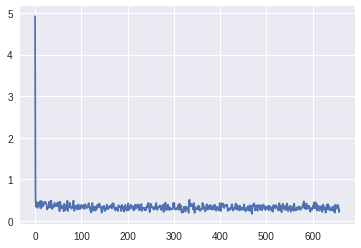

In [351]:
plt.plot(errors)

In [364]:
eva_errors,_,_ = nn(test_X, test_Y, i_h_w, h_o_w, evaluate=True)

Evaluation on test, the average errors is 0.30897


In [354]:
norm_instance.head()

,Latitude,Longitude,Day,Month,Year,Hour,Minute,Second,Magnitude
7640,0.643345,0.647334,0.636364,0.200000,0.392157,0.652174,0.728814,0.389831,5.6
13044,0.640795,0.856904,0.454545,0.033333,0.607843,0.391304,0.627119,0.779661,5.8
21902,0.640111,0.682279,0.727273,0.766667,0.941176,0.565217,0.016949,0.661017,5.6
4333,0.481755,0.263148,0.363636,0.433333,0.235294,0.260870,0.067797,0.677966,5.7
22444,0.471749,0.844140,0.909091,0.466667,0.960784,0.130435,0.135593,0.084746,5.9


In [406]:
instance = norm_instance.sample()
x = instance[['Latitude', 'Longitude', 'Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
y = instance[['Magnitude']]

_,_,_ = nn(x, y, i_h_w, h_o_w,predict=True)

Predict Magnitude: 5.864008, The real magnitude: 5.500000


In [478]:
# Use sklearn
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10), random_state=1)


In [432]:
clf.score(test_X, test_Y)

0.0031481527680036203

In [482]:
instance = norm_instance.sample()
x = instance[['Latitude', 'Longitude', 'Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
y = instance[['Magnitude']]
error = abs(clf.predict(x) - y)
print('Absolute Error: %f' % error.Magnitude)

[[ 6.6]]


NotFittedError: This MLPRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [477]:
from sklearn.model_selection import RandomizedSearchCV

In [480]:
para_dist = {"activation" : ['logistic', 'tanh', 'relu'], 
             "batch_size": [32, 64, 128],
            "momentum": [0.9, 0.6, 0.3]}
random_search = RandomizedSearchCV(clf, param_distributions=para_dist, n_iter= 20)

In [483]:
random_search.fit(train_X, train_Y.values.ravel())

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'activation': ['logistic', 'tanh', 'relu'], 'batch_size': [32, 64, 128], 'momentum': [0.9, 0.6, 0.3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [485]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [486]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.008 (std: 0.003)
Parameters: {'momentum': 0.6, 'batch_size': 64, 'activation': 'tanh'}

Model with rank: 1
Mean validation score: 0.008 (std: 0.003)
Parameters: {'momentum': 0.9, 'batch_size': 64, 'activation': 'tanh'}

Model with rank: 1
Mean validation score: 0.008 (std: 0.003)
Parameters: {'momentum': 0.3, 'batch_size': 32, 'activation': 'tanh'}

Model with rank: 1
Mean validation score: 0.008 (std: 0.003)
Parameters: {'momentum': 0.9, 'batch_size': 32, 'activation': 'tanh'}

Model with rank: 1
Mean validation score: 0.008 (std: 0.003)
Parameters: {'momentum': 0.9, 'batch_size': 128, 'activation': 'tanh'}

Model with rank: 1
Mean validation score: 0.008 (std: 0.003)
Parameters: {'momentum': 0.3, 'batch_size': 64, 'activation': 'tanh'}

